<a href="https://colab.research.google.com/github/tkotani/test/blob/master/periodic_noise_periodic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install denoising-diffusion-pytorch==1.9.5

# 実験条件の設定

In [ ]:
datadir = 'data/masked_loss/'
result_dir = 'masked_loss/'
image_size = 16
padding_size = 156
train_time_steps = 10000
sampling_time_steps = 100

---

# 補助関数の定義  

In [ ]:
import matplotlib.pyplot as plt
def save_image(step,imgs,show=False):
    fig = plt.figure(figsize=(10,10),facecolor="black")
    batch = imgs.shape[0]
    #5枚を一列に並べる,つまり,行数はbatch/5,列数は5
    col = 5
    raw = batch//col
    if batch%col != 0:
        raw += 1
    for i in range(batch):
        ax = fig.add_subplot(raw,col,i+1)
        ax.imshow(imgs[i,step,0], cmap='gray')
        ax.axis('off')
    fig.suptitle(f'Step = {sampling_time_steps-step}', color='white', size=16, y=0.91)
    if show:
        plt.show()
    else:
        plt.savefig(f'images/{step}.png')
        plt.close()

---

# データセットの作成

In [ ]:
import numpy as np
#上記のコードを関数化,引数はimage_sizeとcircle_size,返り値はimg
def create_circle_image(image_size, circle_size):
    img = np.ones((image_size,image_size))
    center = image_size//2
    img[center-circle_size+1:center+circle_size-1, center-circle_size+1:center+circle_size-1] = 0.0
    return img

In [ ]:
def add_corner_points(img, point_size):
    img[:point_size, :point_size] = 0.0
    img[:point_size, -point_size:] = 0.0
    img[-point_size:, :point_size] = 0.0
    img[-point_size:, -point_size:] = 0.0
    return img

In [ ]:
from PIL import Image
import numpy as np
import os
import torchvision
#32x32の画像に4つの点を等間隔に配置する,点の大きさは2*2,画像は白で初期化,なので,16x16の画像に1つの点を配置した画像を複製する
#小さい画像のサイズ
small_image_size = image_size//2
circle_size = 2
img = create_circle_image(small_image_size, circle_size)
#img = add_corner_points(img, point_size=1)
#画像を4つ並べる,画像の大きさは32x32
img = np.tile(img, (2,2))

In [ ]:
#imgを複製して、(padding_size//image_size)+1のサイズの画像を作成する
img = np.tile(img, (padding_size*2//image_size+2,padding_size*2//image_size+2))
#画像をpadding_size*2+image_sizeで切り取る,その時使うのはtorchvision.transforms.CenterCrop
img = Image.fromarray(img)
img = torchvision.transforms.CenterCrop((padding_size*2+image_size,padding_size*2+image_size))(img)
img = np.array(img)

In [ ]:
#画像を保存
image = Image.fromarray(np.uint8(img*255))
for i in range(100):
    #存在しないディレクトリの場合は作成する
    os.makedirs(datadir, exist_ok=True)
    image.save(f"{datadir}/circle_{i}.png")

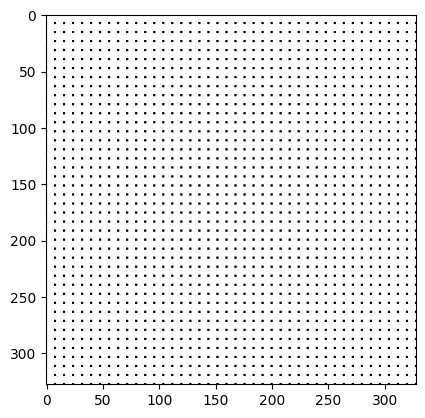

In [ ]:
plt.imshow(img,cmap='gray')

---

# attentionを除いたU-netを定義  

In [ ]:
import torch.nn as nn
import torch
from denoising_diffusion_pytorch.denoising_diffusion_pytorch import default,ResnetBlock,Downsample,Upsample,RandomOrLearnedSinusoidalPosEmb,SinusoidalPosEmb,divisible_by
from functools import partial
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults = (1, 2, 4, 8),
        channels = 3,
        self_condition = False,
        resnet_block_groups = 8,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16,
        sinusoidal_pos_emb_theta = 10000
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings

        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim, theta = sinusoidal_pos_emb_theta)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        #init_convでpaddingを3回行っている
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),#(kernel size = 3, padding = 1)x2=>paddingは2回行っている
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),#(kernel size = 3, padding = 1)x2=>paddingは2回行っている
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)#image sizeを1/2にする=> or  (kernel size = 3, padding = 1)
            ]))
            #一回のレイヤーでpaddingを4回行っている
            #downsamplingのときに

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)#(kernel size = 3, padding = 1)x2
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)#(kernel size = 3, padding = 1)x2

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),#(kernel size = 3, padding = 1)x2
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),#(kernel size = 3, padding = 1)x2
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)#
            ]))

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    @property
    def downsample_factor(self):
        return 2 ** (len(self.downs) - 1)

    def forward(self, x, time, x_self_cond = None):
        assert all([divisible_by(d, self.downsample_factor) for d in x.shape[-2:]]), f'your input dimensions {x.shape[-2:]} need to be divisible by {self.downsample_factor}, given the unet'

        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim = 1)

        x = self.init_conv(x)#kernel size = 7, padding = 3
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2,downsample in self.downs:
            x = block1(x, t)#resnet block,kernel size = 3, padding = 1が
            h.append(x)

            x = block2(x, t)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_block2(x, t)

        for block1, block2,upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

---

---

# ユニットセルでマスクした損失関数の定義

In [ ]:
from denoising_diffusion_pytorch import GaussianDiffusion
import torch
from denoising_diffusion_pytorch.denoising_diffusion_pytorch import default, extract, reduce
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from random import random
from torchvision.transforms import CenterCrop
def p_losses(self, x_start, t, noise = None, offset_noise_strength = None):
    b, c, h, w = x_start.shape

    noise = default(noise, lambda: torch.randn_like(x_start))

    # offset noise - https://www.crosslabs.org/blog/diffusion-with-offset-noise

    offset_noise_strength = default(offset_noise_strength, self.offset_noise_strength)

    if offset_noise_strength > 0.:
        offset_noise = torch.randn(x_start.shape[:2], device = self.device)
        noise += offset_noise_strength * rearrange(offset_noise, 'b c -> b c 1 1')

    # noise sample

    x = self.q_sample(x_start = x_start, t = t, noise = noise)

    # if doing self-conditioning, 50% of the time, predict x_start from current set of times
    # and condition with unet with that
    # this technique will slow down training by 25%, but seems to lower FID significantly

    x_self_cond = None
    if self.self_condition and random() < 0.5:
        with torch.inference_mode():
            x_self_cond = self.model_predictions(x, t).pred_x_start
            x_self_cond.detach_()

    # predict and take gradient step

    model_out = self.model(x, t, x_self_cond)

    if self.objective == 'pred_noise':
        target = noise
    elif self.objective == 'pred_x0':
        target = x_start
    elif self.objective == 'pred_v':
        v = self.predict_v(x_start, t, noise)
        target = v
    else:
        raise ValueError(f'unknown objective {self.objective}')

    #指定した領域のみを使って損失関数を計算する, 今回は中心から半径10の領域を切り取り、その領域のみを使って損失関数を計算する

    crop_size = image_size
    crop = CenterCrop(crop_size)
    model_out = crop(model_out)
    target = crop(target)


    loss = F.mse_loss(model_out, target, reduction = 'none')
    loss = reduce(loss, 'b ... -> b', 'mean')

    loss = loss * extract(self.loss_weight, t, loss.shape)
    return loss.mean()
GaussianDiffusion.p_losses = p_losses

---

# 周期的なノイズでのサンプリングメソット

In [ ]:
from tqdm import tqdm
class PeriodicNoiseDiffusion(GaussianDiffusion):
    @torch.inference_mode()
    def ddim_sample_from_periodic_noise(self, shape, return_all_timesteps = False):
        batch, device, total_timesteps, sampling_timesteps, eta, objective = shape[0], self.device, self.num_timesteps, self.sampling_timesteps, self.ddim_sampling_eta, self.objective

        times = torch.linspace(-1, total_timesteps - 1, steps = sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

        img = torch.randn(shape, device = device)

        #imgのdeviceを揃える
        img = img.to(device)

        imgs = [img]

        x_start = None

        croper = torchvision.transforms.CenterCrop(shape[-2:])

        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            time_cond = torch.full((batch,), time, device = device, dtype = torch.long)
            self_cond = x_start if self.self_condition else None

            #imgのサイズを3倍にする
            img = img.repeat(1,1,3,3)

            pred_noise, x_start, *_ = self.model_predictions(img, time_cond, self_cond, clip_x_start = True, rederive_pred_noise = True)

            #元に戻す
            img = croper(img)
            x_start = croper(x_start)
            pred_noise = croper(pred_noise)

            if time_next < 0:
                img = x_start
                imgs.append(img)
                continue

            alpha = self.alphas_cumprod[time]
            alpha_next = self.alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(img)

            img = x_start * alpha_next.sqrt() + \
                c * pred_noise + \
                sigma * noise
            imgs.append(img)
            #cudaのメモリを解放する
            torch.cuda.empty_cache()
        ret = img if not return_all_timesteps else torch.stack(imgs, dim = 1)
        ret = self.unnormalize(ret)
        return ret

# Trainerのインスタンス化

In [ ]:
from denoising_diffusion_pytorch import Trainer

In [ ]:
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4),
    channels=1
)

diffusion = PeriodicNoiseDiffusion(
    model,
    image_size = padding_size*2+image_size,
    timesteps = train_time_steps,               # number of steps
    sampling_timesteps = sampling_time_steps    # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
)
trainer = Trainer(
    diffusion,
    datadir,
    train_batch_size = 8,
    train_lr = 8e-5,
    train_num_steps = 100,           # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
    calculate_fid = False,             # whether to calculate fid during training
    results_folder=result_dir,
    num_fid_samples = 100
)

# トレーニング

In [ ]:
trainer.train()

  0%|          | 0/100 [00:00<?, ?it/s]

training complete


In [ ]:
trainer.save('model')

---

# サンプリング

In [ ]:
trainer.load('model')

## 通常のサンプリング

In [ ]:
#sampling.shapeはbatch,channnel,height,width
batch,channel,height,width = 25,1,image_size*5,image_size*5
shape = (batch,channel,height,width)
sampling = trainer.model.ddim_sample(shape,return_all_timesteps=True)
sampling = sampling.cpu().numpy()

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

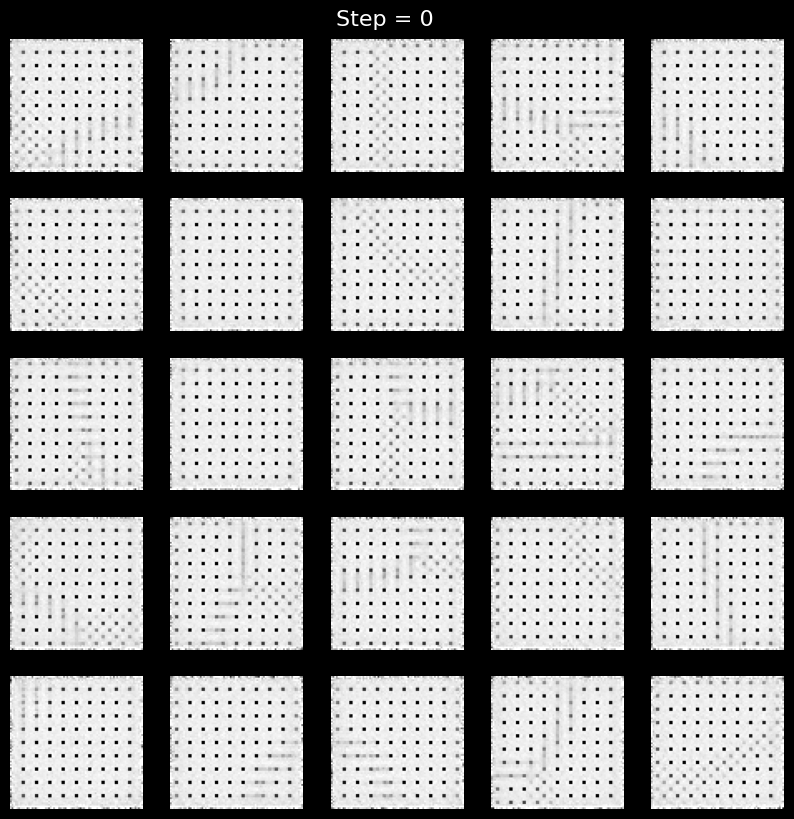

In [ ]:
save_image(sampling_time_steps,sampling,show=True)

## 周期パディングでのサンプリング

In [ ]:
#withに対応するクラスを定義
def patch_conv(cls,padding_mode):
	init = cls.__init__
	def __init__(self, *args, **kwargs):
		#kwargsにpadding_modeが含まれている場合はその情報をremoveする
		if 'padding_mode' in kwargs:
			del kwargs['padding_mode']
		return init(self, *args, **kwargs, padding_mode=padding_mode)
	cls.__init__ = __init__

from torch import nn
class ChangePaddingMode:
	#cnnのpadding_modeを変更する
	def __init__(self,padding_mode='circular'):
		self.padding_mode = padding_mode
	def __enter__(self):
		#オリジナルのinitを保持
		self.original_init_conv2d = nn.Conv2d.__init__
		#padding_modeを変更
		patch_conv(nn.Conv2d, self.padding_mode)
		return
	def __exit__(self, type, value, traceback):
		#padding_modeを元に戻す
		nn.Conv2d.__init__ = self.original_init_conv2d
		return False

In [ ]:
with ChangePaddingMode(padding_mode='circular'):
  model_circular = Unet(
      dim = 64,
      dim_mults = (1, 2, 4),
      channels=1
  )
  diffusion_circular = PeriodicNoiseDiffusion(
      model_circular,
      image_size = padding_size*2+image_size,
      timesteps = train_time_steps,               # number of steps
      sampling_timesteps = sampling_time_steps    # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
  )
  trainer_circular = Trainer(
      diffusion_circular,
      datadir,
      train_batch_size = 8,
      train_lr = 8e-5,
      train_num_steps = 100,           # total training steps
      gradient_accumulate_every = 2,    # gradient accumulation steps
      ema_decay = 0.995,                # exponential moving average decay
      amp = True,                       # turn on mixed precision
      calculate_fid = False,             # whether to calculate fid during training
      results_folder=result_dir,
      num_fid_samples = 100
  )

In [ ]:
trainer_circular.load('model')

loading from version 1.9.5


In [ ]:
#sampling.shapeはbatch,channnel,height,width
batch,channel,height,width = 25,1,4*36,4*36 #image_size*5,image_size*5
shape = (batch,channel,height,width)
sampling = trainer_circular.model.ddim_sample(shape,return_all_timesteps=True)
sampling = sampling.cpu().numpy()

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

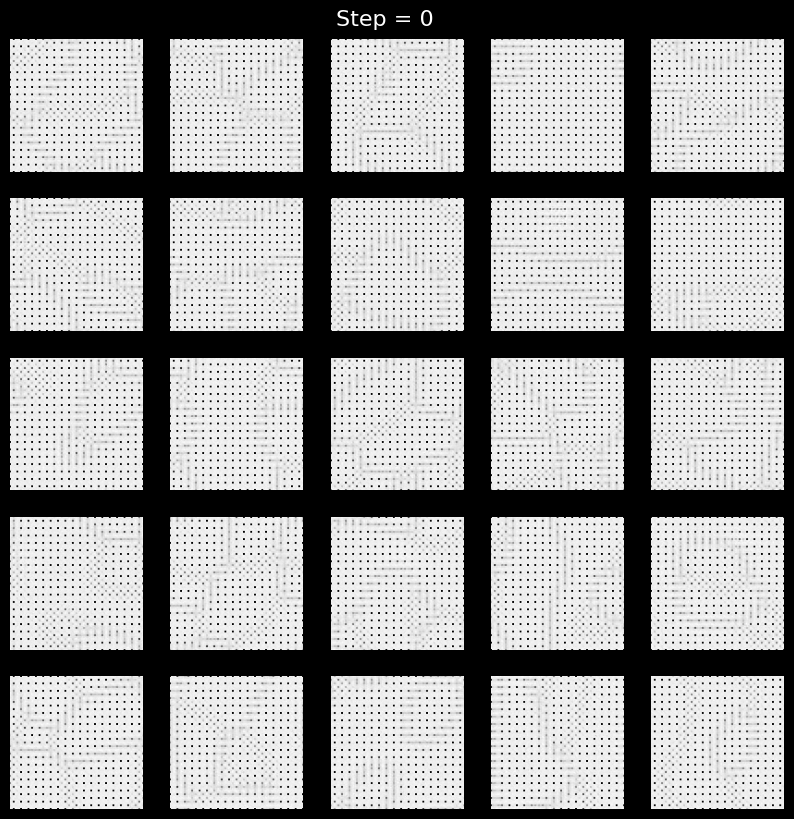

In [ ]:
save_image(sampling_time_steps,sampling,show=True)

## 周期的なノイズでのサンプリング

In [ ]:
batch,channel,height,width = 25,1,image_size*3,image_size*3
shape = (batch,channel,image_size,image_size)
sampling = trainer.model.ddim_sample_from_periodic_noise(shape,return_all_timesteps=True)
sampling = sampling.cpu()
sampling = sampling.repeat(1,1,1,3,3).numpy()

sampling loop time step: 100%|██████████| 100/100 [00:04<00:00, 23.19it/s]


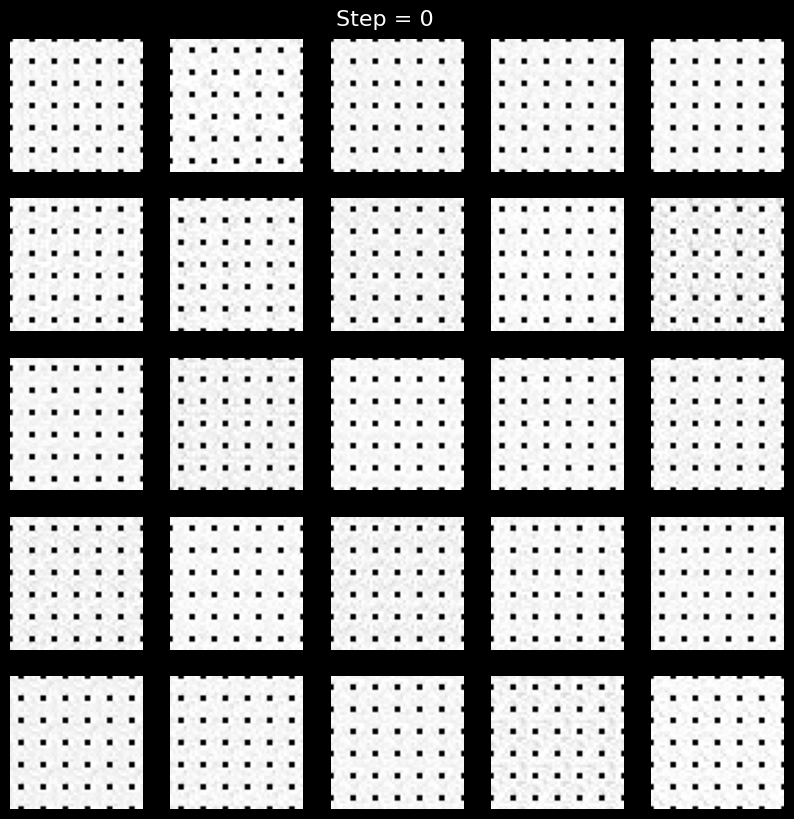

In [ ]:
save_image(sampling_time_steps,sampling,show=True)